In [31]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from surprise import Dataset, Reader, accuracy , KNNWithMeans
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV
from surprise.prediction_algorithms import SVD, SVDpp, NormalPredictor , BaselineOnly

plt.style.use('fast')
%matplotlib inline

In [32]:
music_review2=pd.read_csv('./Data/music_review.csv')

In [33]:
music_review2.asin.nunique()

456811

In [34]:
music_review2.reviewerID.nunique()

839565

In [35]:
music_review2.isna().sum()

Unnamed: 0    0
overall       0
reviewerID    0
asin          0
reviewText    5
dtype: int64

In [36]:
music_review2=music_review2.drop('Unnamed: 0' , axis=1 )

In [37]:
music_review2.dropna(inplace=True)

grouby by asin and join review text 

In [38]:
music_review2.head()

,overall,reviewerID,asin,reviewText
0,5,A1ZCPG3D3HGRSS,0001388703,This is a great cd full of worship favorites!!...
1,5,AC2PL52NKPL29,0001388703,"So creative! Love his music - the words, the ..."
2,5,A1SUZXBDZSDQ3A,0001388703,"Keith Green, gone far to early in his carreer,..."
3,5,A3A0W7FZXM0IZW,0001388703,Keith Green had his special comedy style of Ch...
4,5,A12R54MKO17TW0,0001388703,Keith Green / So you wanna go back to Egypt......


In [39]:
music_review2.reviewerID.value_counts()

A3W4D8XOGLWUN5    1255
AQ4B80F0JSBNI      660
A1Q0BU32CVOLRA     638
A2WQY1B8ZS7QRZ     534
A2H3JURQZOHVMB     484
                  ... 
AFBG40Y41PMP1        1
ANJJ2GRCUC9WW        1
A2NJJ5AWS82JXC       1
AS4DT06XYULE1        1
A253GR2CID06AA       1
Name: reviewerID, Length: 839565, dtype: int64

In [40]:
# Count the occurrences of each reviewer ID
reviewer_counts = music_review2['reviewerID'].value_counts()

# Find reviewer IDs with count equals to 1
reviewer_ids_to_drop = reviewer_counts[reviewer_counts == 1].index

# Drop rows where reviewer ID is in the list of IDs to drop
music_review2 = music_review2[~music_review2['reviewerID'].isin(reviewer_ids_to_drop)]


In [41]:
music_review2.asin.value_counts()

B00CZF8B68    1661
B00M8JCW3E     865
B00NPZI1ZS     767
B00BWGHIHY     762
B0092MKTL2     746
              ... 
B005562DVS       1
B005O9BZII       1
B00AR8F690       1
B00005642Q       1
B0129VHW26       1
Name: asin, Length: 333636, dtype: int64

In [42]:
# Count the occurrences of each reviewer ID
asin_counts = music_review2['asin'].value_counts()

# Find reviewer IDs with count equals to 1
asin_to_drop = asin_counts[asin_counts == 1].index

# Drop rows where reviewer ID is in the list of IDs to drop
music_review2 = music_review2[~music_review2['reviewerID'].isin(reviewer_ids_to_drop)]

normalize the rating ,cause i have 5 only 

<AxesSubplot:xlabel='overall', ylabel='Count'>

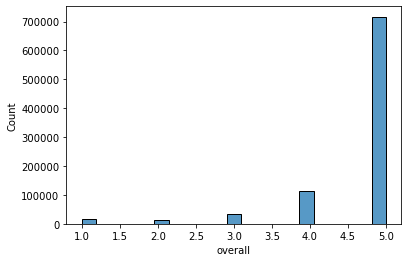

In [43]:
sns.histplot(music_review2.overall)

normalize review

In [44]:
music_review2.columns

Index(['overall', 'reviewerID', 'asin', 'reviewText'], dtype='object')

In [45]:
music_review2.isna().sum()

overall       0
reviewerID    0
asin          0
reviewText    0
dtype: int64

In [46]:
# Convert 'overall' column to integers
music_review2['overall'] = music_review2['overall'].astype(int)

# Calculate average rating for each reviewer
reviewer_avg_ratings = music_review2.groupby('reviewerID')['overall'].mean().reset_index()

# Merge the average ratings back into the DataFrame
music_review2 = music_review2.merge(reviewer_avg_ratings, on='reviewerID', suffixes=('', '_avg'))

# Subtract average rating from each rating
music_review2['normalized_rating'] = music_review2['overall'] - music_review2['overall_avg']

In [47]:
music_review2.normalized_rating.min(),music_review2.normalized_rating.max()

(-3.973140495867769, 3.891891891891892)

First_simple_Modeling

NoramlPredictor

In [48]:
reader = Reader(rating_scale=(-3.973140495867769, 3.891891891891892))
music_review = Dataset.load_from_df(music_review2[['reviewerID', 'asin', 'normalized_rating']], reader)

trainset, testset = train_test_split(music_review, test_size=0.2, random_state=42)


In [49]:
baseline = NormalPredictor()
baseline.fit(trainset)

# Return test predictions for model fit on trainset
predictions = baseline.test(testset)

# Save RMSE score to variable
results = cross_validate(baseline, music_review, measures=['RMSE'], cv=5, verbose=True)

# Average RMSE
average_rmse = sum(results['test_rmse']) / len(results['test_rmse'])
print(f'Average RMSE using NormalPredictor: {average_rmse}')

Evaluating RMSE of algorithm NormalPredictor on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.7905  0.7873  0.7892  0.7868  0.7839  0.7875  0.0022  
Fit time          1.17    1.49    1.56    1.77    1.51    1.50    0.19    
Test time         1.25    1.22    1.34    1.25    1.27    1.26    0.04    
Average RMSE using NormalPredictor: 0.7875308251177435


baseline only

In [50]:
# Instantiate and fit model
baseline2 = BaselineOnly()
baseline2.fit(trainset)

# Return test predictions for model fit on trainset
predictions = baseline2.test(testset)

# Save RMSE score to variable
baseline_only = accuracy.rmse(predictions)

results = cross_validate(baseline2, music_review, measures=['RMSE'], cv=5, verbose=True)

# Average RMSE
average_rmse = sum(results['test_rmse']) / len(results['test_rmse'])
print(f'Average RMSE using NormalPredictor: {average_rmse}')

Estimating biases using als...
RMSE: 0.5747
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Evaluating RMSE of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.5726  0.5764  0.5740  0.5687  0.5731  0.5730  0.0025  
Fit time          4.81    4.84    5.10    4.81    4.88    4.89    0.11    
Test time         1.11    0.98    0.95    0.93    1.05    1.00    0.07    
Average RMSE using NormalPredictor: 0.5729501518000507


SVD

In [51]:
# Cross validate a basic SVD with no hyperparameter tuning expecting sub-par results
svd_basic = SVD(random_state=42)
results = cross_validate(svd_basic, music_review, measures=['RMSE'], cv=3, n_jobs = -1, verbose=True)

# Average RMSE
average_rmse = sum(results['test_rmse']) / len(results['test_rmse'])
print(f'Average RMSE using SVD basic: {average_rmse}')

Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.5832  0.5848  0.5857  0.5846  0.0010  
Fit time          50.21   48.35   49.45   49.34   0.76    
Test time         3.76    3.66    3.41    3.61    0.15    
Average RMSE using NormalPredictor: 0.5845826871993706


In [52]:
svd_basic.fit(trainset)
predictions = svd_basic.test(testset)
svd_simple = accuracy.rmse(predictions)

RMSE: 0.5897


SVD grid search

dont run this

In [53]:
# # Define a range of hyperparameters for GridSearchCV with SVD++
# param_grid = {
#     'n_factors': [50, 100, 150],  # Number of factors
#     'n_epochs': [20, 30],  # Number of epochs
#     'lr_all': [0.005, 0.01],  # Learning rate
#     'reg_all': [0.02, 0.1]  # Regularization term
# }

# # Setup GridSearchCV with SVD++
# gs_svd = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# # Fit the model
# gs_svd.fit(music_review)

# # Best score and parameters
# best_rmse = gs_svd.best_score['rmse']
# best_params = gs_svd.best_params['rmse']

# print(f"Best RMSE: {best_rmse}")
# print(f"Best parameters: {best_params}")


Best RMSE: 1.0993641323939394

Best parameters: {'n_factors': 50, 'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.1}

In [55]:
svd_2= SVD(n_factors=50, n_epochs= 30, lr_all=0.01, reg_all= 0.1, random_state=42)
results = cross_validate(svd_2, music_review, measures=['RMSE'], cv=3, n_jobs = -1, verbose=True)

# Average RMSE
average_rmse_2 = sum(results['test_rmse']) / len(results['test_rmse'])
print(f'Average RMSE using svd_2 after gride search: {average_rmse_2}')

Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.6122  0.6123  0.6137  0.6128  0.0007  
Fit time          42.80   42.87   43.07   42.91   0.12    
Test time         3.47    3.45    3.19    3.37    0.13    
Average RMSE using NormalPredictor: 0.6127534895318506


In [56]:
svd_2.fit(trainset)
predictions = svd_2.test(testset)
svd_simple = accuracy.rmse(predictions)

RMSE: 0.6198


second gride search

In [58]:
# Setup new hyperparameter dictionary
svd_param_grid2 = {'n_factors':[5, 20],
                  'n_epochs': [20, 40], 
                  'lr_all': [0.05, .005],
                  'reg_all': [0.01, 0.02]}
svd_gr_3 = GridSearchCV(SVD,param_grid=svd_param_grid2,joblib_verbose=10, n_jobs=-1, cv=3)

# Return best_params based on RMSE
svd_gr_3 .fit(music_review)
svd_gr_3 .best_params['rmse']

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  38 out of  48 | elapsed:  5.8min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  43 out of  48 | elapsed:  6.1min remaining:   42.5s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  7.0min finished


{'n_factors': 5, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.02}

In [59]:
svd_3= SVD(n_factors=5, n_epochs= 20, lr_all=0.005, reg_all= 0.02, random_state=42)
results = cross_validate(svd_3, music_review, measures=['RMSE'], cv=3, n_jobs = -1, verbose=True)

# Average RMSE
average_rmse_3 = sum(results['test_rmse']) / len(results['test_rmse'])
print(f'Average RMSE using svd_3 after gride search: {average_rmse_3}')

Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.5814  0.5816  0.5833  0.5821  0.0008  
Fit time          13.69   13.53   12.80   13.34   0.39    
Test time         3.27    3.27    3.31    3.29    0.02    
Average RMSE using svd_3 after gride search: 0.5820953708485335


In [61]:
svd_3.fit(trainset)
predictions = svd_3.test(testset)
svd_simple_3 = accuracy.rmse(predictions)

RMSE: 0.5871


SVD++

In [63]:
# Instantiate - fit on trainset - score the model on testset
SVDpp_basic= SVDpp(n_factors=1, n_epochs=25, random_state=42, reg_all=0.05)
SVDpp_basic.fit(trainset)
predictions = SVDpp_basic.test(testset)
SVDpp_gs = accuracy.rmse(predictions)

RMSE: 0.6042


svd ++ gride search

In [67]:
param_grid = {
    'n_factors': [50, 100, 150],  # Number of factors
    'n_epochs': [20, 30],  # Number of epochs
    'lr_all': [0.005, 0.01],  # Learning rate
    'reg_all': [0.02, 0.1]  # Regularization term
}

# Setup GridSearchCV with SVD++
gs_svdpp = GridSearchCV(SVDpp, param_grid, measures=['rmse', 'mae'], joblib_verbose=10, n_jobs=-1, cv=3)

# Return best_params based on RMSE
gs_svdpp .fit(music_review)
gs_svdpp .best_params['rmse']

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 25.9min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 32.6min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 750.3min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 772.4min
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Windows-10\anaconda3\envs\learn-env\lib\site-packages\IPython\core\interactiveshell.py", line 3417, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-67-8b02ac510bb3>", line 12, in <module>
    gs_svdpp .fit(music_review)
  File "C:\Users\Windows-10\anaconda3\envs\learn-env\lib\site-packages\surprise\model_selection\search.py", line 88, in fit
    out = Parallel(n_jobs=self.n_jobs,
  File "C:\Users\Windows-10\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1952, in __call__
    return output if self.return_generator else list(output)
  File "C:\Users\Windows-10\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1595, in _get_outputs
    yield from self._retrieve()
  File "C:\Users\Windows-10\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1707, in _retrieve
    time.sleep(0.01)
KeyboardInterrupt

During handling of the above exception, a

TypeError: object of type 'NoneType' has no len()